# Example 2: Simulating an Electric Vehicle with an ECM

In this example, we will perform a full simulation of an electric vehicle based on trip data from the earlier example. It is assumed that the traffic in the last example has been simulated already and that the trip files are stored in a folder named 'simulated_trip_files'.

The vehicle and battery pack simulations are handled by the 'Vehicle' and 'Pack' classes.

In [1]:
from tracksim.tracksim import Vehicle, Pack

In order to perform the simulation, we first need to define the type of vehicle, the type of battery pack, and the type of cells within the pack. We will use already defined models available in the package. In this example, we will use a first order Equivalent Circuit Model (ECM) with dynamic parameters to model each cell. The model is represented by the state-space model

$$\rho[k] = \begin{cases} \eta, & I[k] > 0 \\ 1, & \text{otherwise} \end{cases}$$
$$SOC[k] = SOC[k-1] + \frac{\Delta t}{Q\cdot3600}\rho[k-1]I[k-1]$$
$$I_{RC}[k] = \exp\left\{\frac{-\Delta t}{R_1 C_1}\right\}I_{RC}[k-1] + \left(1-\exp\left\{\frac{-\Delta t}{R_1 C_1)}\right\}\right)I[k-1]$$
$$V_t[k] = OCV\left(SOC[k-1]\right) + R_1 I_{RC}[k] + R_0I[k]$$

where $k$ is the sample index $I$ is the load current (assumed to be positive when charging), $V_t$ is the terminal cell voltage, $\eta$ is the Coulombic efficiency, $\Delta t$ is the sampling time, $Q$ is the capacity of the cell in Ah, $I_{RC}$ is the diffusion current, and $OCV$ is the $SOC$ dependent open circuit voltage. The resistances and capacitance, $R_0$, $R_1$, and $C_1$, are SOC and Temperature dependent i.e.

$$R_0 = R_0(SOC, T), \quad R_1 = R_1(SOC, T), \quad C_1 = C_1(SOC, T)$$

In [2]:
from tracksim.vehicle_models import ChevyVoltTuned
from tracksim.pack_models import ChevyVoltPack
from tracksim.cell_models import load_Zheng2024 # first order ECM with dynamic parameters

vehicle_model = ChevyVoltTuned.copy()
pack_model = ChevyVoltPack.copy()
cell_model = load_Zheng2024()

Each model is stored as a dictionary following a format compatible with TRACKSIM. For example, the cell model holds the following information.

In [3]:
print(vehicle_model, '\n')
print(pack_model, '\n')
print(cell_model)

{'Model name': 'ChevyVoltTuned', 'Reference': 'G. L. Plett, Battery Management Systems, Volume 2: Equivalent Circuit Methods. in Artech House Power engineering series. Boston: Artech house, 2016.', 'Description': 'A modified version of ChevyVolt with higher maximum motor torque and RPM.', 'Number of wheels': 4, 'Brake drag [N]': 0, 'Drag coefficient': 0.22, 'Frontal area [m2]': 1.84, 'Mass [kg]': 1425, 'Payload [kg]': 75, 'Overhead power [W]': 200, 'Inverter efficiency': 0.94, 'Fractional regen torque limit': 0.9, 'Gear ratio': 12, 'Gear inertia [kg/m2]': 0.05, 'Gear efficiency': 0.97, 'Wheel radius [m]': 0.35, 'Wheel inertia [kg/m2]': 8, 'Rolling coefficient': 0.0111, 'Max motor torque [Nm]': 1420, 'Rated RPM [RPM]': 4000, 'Max RPM [RPM]': 23000, 'Motor efficiency': 0.95, 'Motor inertia [kg/m2]': 0.2} 

{'Model name': 'ChevyVoltPack', 'Reference': 'G. L. Plett, Battery Management Systems, Volume 2: Equivalent Circuit Methods. in Artech House Power engineering series. Boston: Artech ho

If you are curious where these models come from, you can check the reference in the dictionary.

In [4]:
print(vehicle_model['Reference'])
print(pack_model['Reference'])
print(cell_model['Reference'])

G. L. Plett, Battery Management Systems, Volume 2: Equivalent Circuit Methods. in Artech House Power engineering series. Boston: Artech house, 2016.
G. L. Plett, Battery Management Systems, Volume 2: Equivalent Circuit Methods. in Artech House Power engineering series. Boston: Artech house, 2016.
Y. Zheng, Y. Che, X. Hu, X. Sui, and R. Teodorescu, “Online Sensorless Temperature Estimation of Lithium-Ion Batteries Through Electro-Thermal Coupling,” IEEE/ASME Transactions on Mechatronics, vol. 29, no. 6, pp. 4156–4167, Dec. 2024, doi: 10.1109/TMECH.2024.3367291.


Setting up the vehicle and the battery pack with these models is straightforward. First, the pack is defined using the pack and cell models and then the vehicle is configured with the vehicle model and the defined pack.

In [5]:
pack = Pack(pack_model, cell_model)
vehicle = Vehicle(vehicle_model, pack)

That's it! Now we can simulate the vehicle and the battery pack. The full simulation follows 2 steps:

1. Simulate the battery power demand based on a desired vehicle speed profile
2. Simulate the battery pack based on the power demand profile

In [6]:
import pandas as pd
from tracksim.utils import exp_average

# Get trip data

trip_file = 'simulated_trip_files/veh0.csv'
trip_data = pd.read_csv(trip_file)

time = trip_data['Time [s]']
sample_period = time[1] - time[0]
speed = exp_average(trip_data['Speed [m/s]'], 0.4) # Low-pass filter to make a more realistic speed profile

# Set initial battery conditions

soc_init = 0.8 # Initial State Of Charge (SOC)

vehicle.simulate_vehicle(time, speed, sample_period)
vehicle.simulate_battery_pack(initial_soc=soc_init)


The simulation results for the vehicle and the battery pack are stored in their own dictionaries. These can be accessed by:

In [7]:
print(vehicle.simulation_results,'\n')
print(pack.simulation_results)

{'Time [s]': array([   0,    1,    2, ..., 1299, 1300, 1301], shape=(1302,)), 'Sample period [s]': np.int64(1), 'Desired speed [m/s]': array([ 0.        ,  0.93601409,  2.29252483, ..., 16.73673895,
       16.82226388, 17.095066  ], shape=(1302,)), 'Desired acceleration [m/s2]': array([0.        , 0.93601409, 1.35651074, ..., 0.1954083 , 0.08552493,
       0.27280212], shape=(1302,)), 'Desired acceleration force [N]': array([   0.        , 1853.40341658, 2686.02968308, ...,  386.92838014,
        169.34809667,  540.17602561], shape=(1302,)), 'Aerodynamic force [N]': array([ 0.        ,  0.        ,  0.21722578, ..., 67.8402567 ,
       69.45256369, 70.16418409], shape=(1302,)), 'Rolling grade force [N]': array([  0.        ,   0.        , 196.09848783, ..., 196.09848783,
       196.09848783, 196.09848783], shape=(1302,)), 'Torque demand [Nm]': array([ 0.        , 54.05759965, 84.0684074 , ..., 18.98362447,
       12.68455849, 23.52112868], shape=(1302,)), 'Max torque [Nm]': array([1420

Now we can plot some simulation results. First, we might be interested in the vehicle speed, acceleration, and the resulting battery power demand.

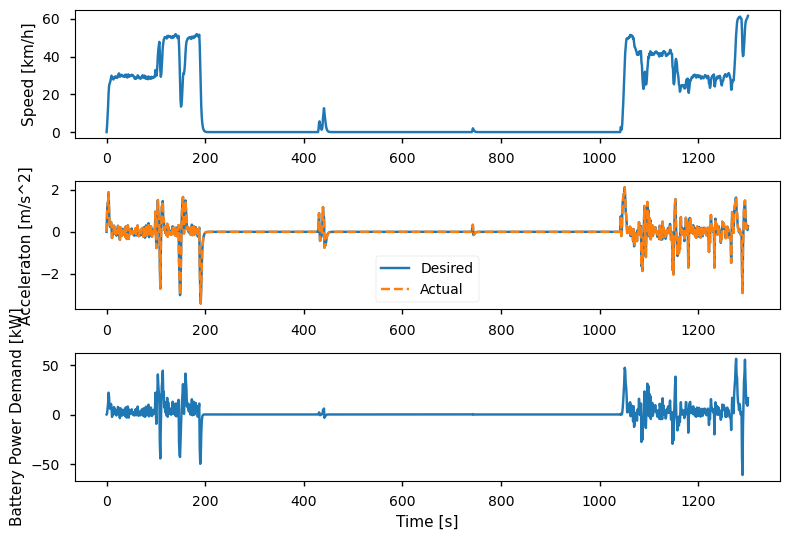

In [8]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-notebook')

fig, ax = plt.subplots(nrows=3)
ax[0].plot(vehicle.simulation_results['Desired speed [m/s]']*3.6)
ax[0].set_ylabel('Speed [km/h]')
ax[1].plot(vehicle.simulation_results['Desired acceleration [m/s2]'], label='Desired')
ax[1].set_ylabel('Acceleraton [m/s^2]')
ax[1].plot(vehicle.simulation_results['Actual acceleration [m/s2]'], linestyle='--', label='Actual')
ax[1].legend()
ax[2].plot(vehicle.simulation_results['Battery power demand [W]']/1000)
ax[2].set_ylabel('Battery Power Demand [kW]')
ax[2].set_xlabel('Time [s]')

fig.tight_layout()


We can also plot simulation results for the battery pack.

In [9]:
pack.simulation_results['Pack'].keys()

dict_keys(['Current [A]', 'Voltage [V]', 'Min SOC', 'Max SOC', 'Avg SOC', 'Min temperature [C]', 'Max temperature [C]', 'Avg temperature [C]'])

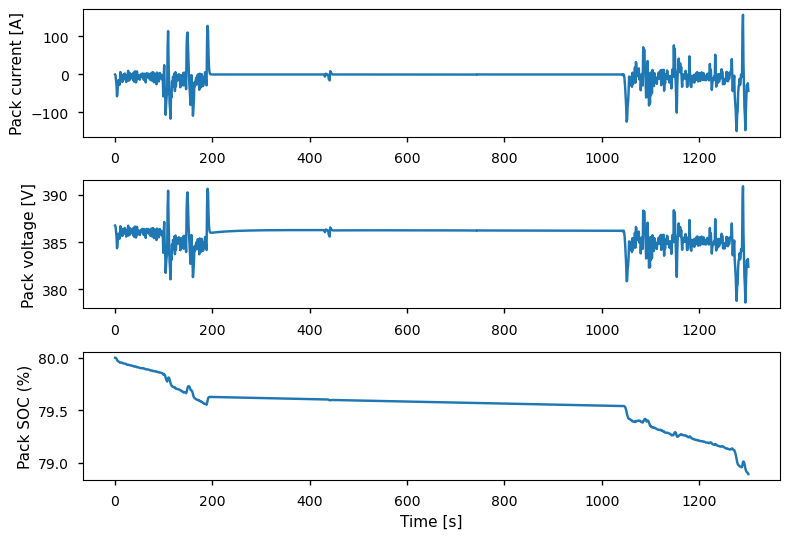

In [10]:
fig, ax = plt.subplots(nrows=3)
ax[0].plot(pack.simulation_results['Pack']['Current [A]'])
ax[0].set_ylabel('Pack current [A]')
ax[1].plot(pack.simulation_results['Pack']['Voltage [V]'])
ax[1].set_ylabel('Pack voltage [V]')
ax[2].plot(pack.simulation_results['Pack']['Avg SOC']*100)
ax[2].set_ylabel('Pack SOC (%)')
ax[2].set_xlabel('Time [s]')

fig.tight_layout()

We can also extract the current, voltage, and soc for each cell in the battery pack.

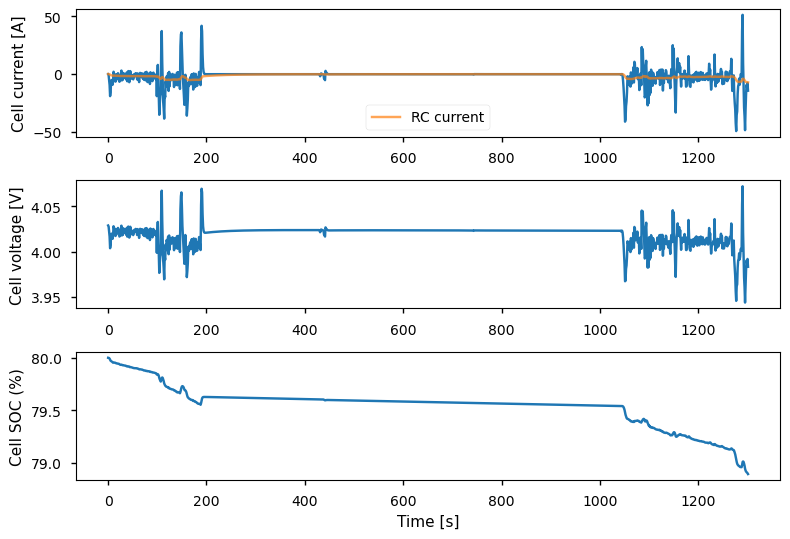

In [11]:
cell_i, cell_j = (0,0) # Cell index

fig, ax = plt.subplots(nrows=3)
ax[0].plot(pack.simulation_results[f'Cell {cell_i}-{cell_j}']['Current [A]'])
ax[0].plot(pack.simulation_results[f'Cell {cell_i}-{cell_j}']['RC1 current [A]'], alpha=0.7, label='RC current')
ax[0].legend()
ax[0].set_ylabel('Cell current [A]')
ax[1].plot(pack.simulation_results[f'Cell {cell_i}-{cell_j}']['Voltage [V]'])
ax[1].set_ylabel('Cell voltage [V]')
ax[2].plot(pack.simulation_results[f'Cell {cell_i}-{cell_j}']['SOC']*100)
ax[2].set_ylabel('Cell SOC (%)')
ax[2].set_xlabel('Time [s]')

fig.tight_layout()


We can also extract the dynamic ECM parameters and see how they vary over time.

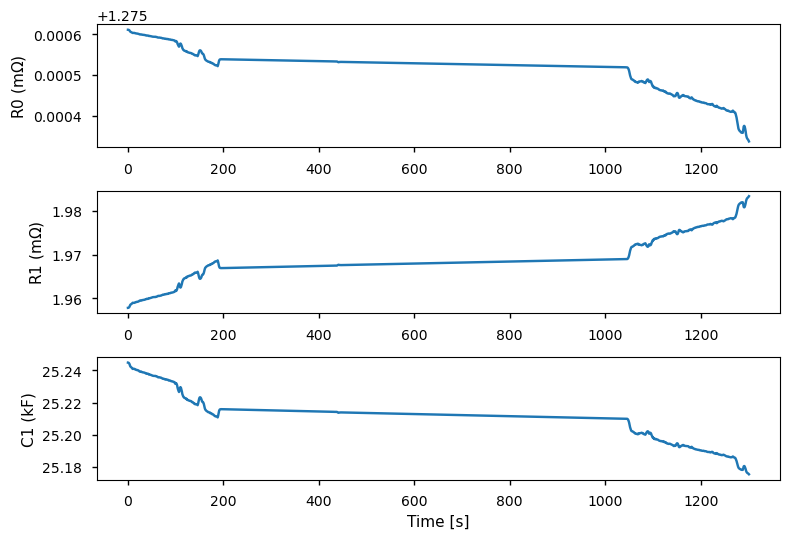

In [12]:
R0 = vehicle.pack.simulation_results['Cell 0-0']['R0 [Ohm]']
R1 = vehicle.pack.simulation_results['Cell 0-0']['R1 [Ohm]']
C1 = vehicle.pack.simulation_results['Cell 0-0']['C1 [F]']

fig, ax = plt.subplots(nrows=3)
ax[0].plot(R0*1000)
ax[0].set_ylabel(r'R0 (m$\Omega$)')
ax[1].plot(R1*1000)
ax[1].set_ylabel(r'R1 (m$\Omega$)')
ax[2].plot(C1/1000)
ax[2].set_ylabel('C1 (kF)')
ax[2].set_xlabel('Time [s]')

fig.tight_layout()

If you just need a quick overview of the vehicle and battery profiles, you can pass the fully simulated vehicle to the 'plot_vehicle_and_battery_data' function from the 'utils' module.

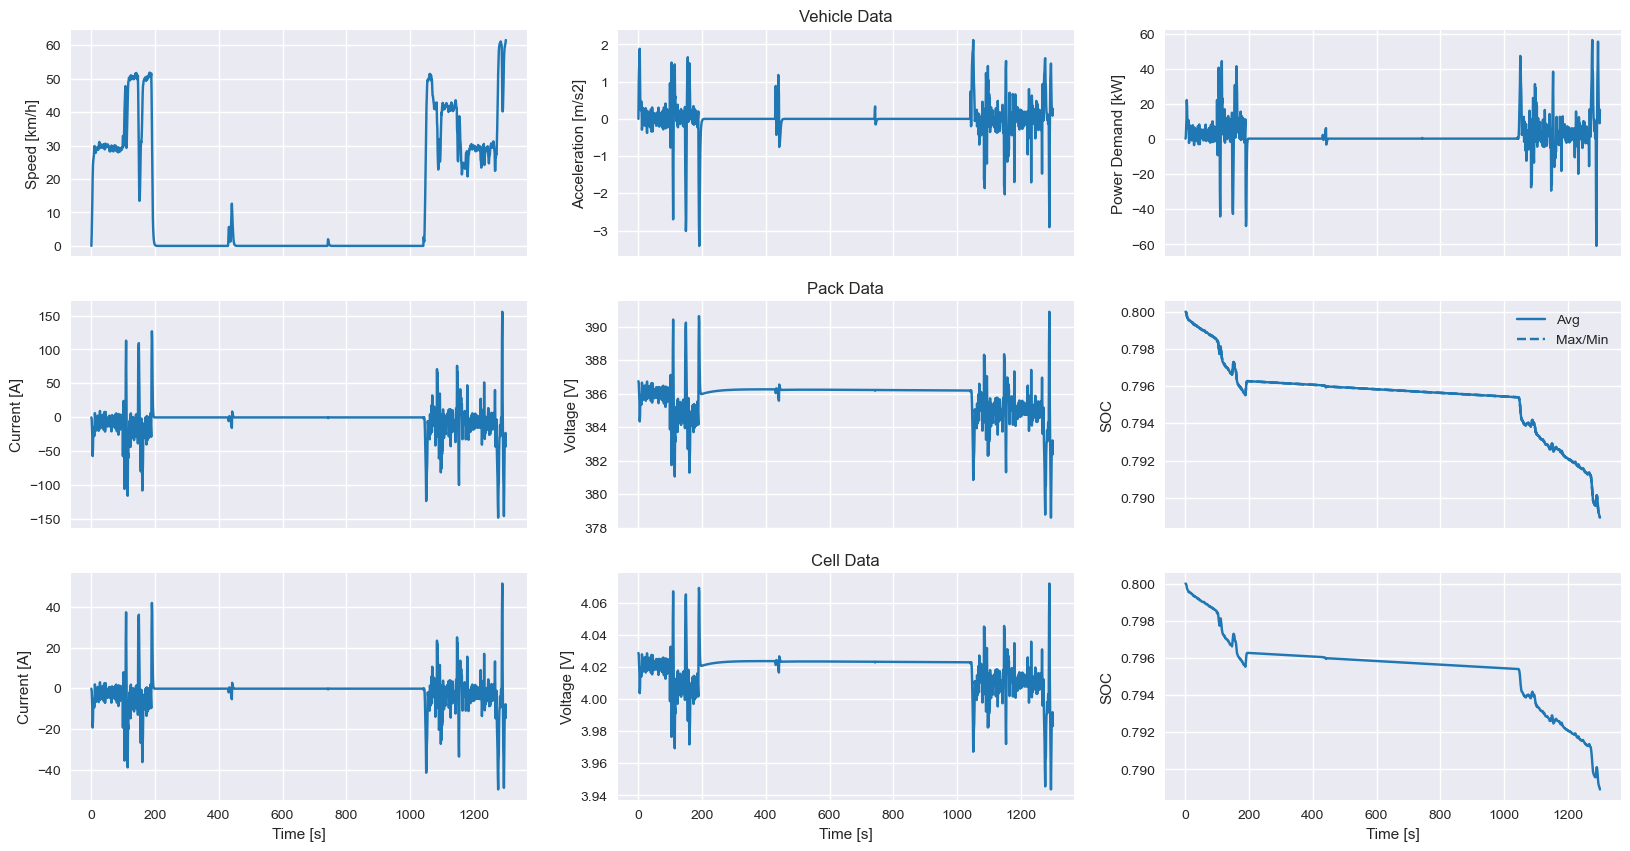

In [13]:
from tracksim.utils import plot_vehicle_and_battery_data

fig, ax = plot_vehicle_and_battery_data(vehicle)